# Time Series and Forecasting 
# Goal : To analyze the data leading upto Volkswagen buyout of Porsche

In [1]:

import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from pmdarima.arima import OCSBTest 
from statsmodels.tsa.arima_model import ARIMA
from arch import arch_model
import seaborn as sns
import yfinance 
import warnings
warnings.filterwarnings("ignore")
sns.set()


## Importing the Data

In [2]:
#  Directky scrapping the data from Yahoo finance instead of importing fixed data  
#  The abbreveations for certain equities on the stock market are : VOW3-Volkswagen, PAH3 -Porsche, BMW-Bayerische Motoren Werke AG
# .DE shows the data are from German stock market since, both the companies are German based.
#  To make sure all the changes or values are stock specific we nedd to market benchmark. 
     # Ideally this wolud be some other German automobile comapny selling stocks in the German market.
     # So BMW is the obvious choice 
        

raw_data = yfinance.download (tickers = "VOW3.DE, PAH3.DE, BMW.DE", interval = "1d", group_by = 'ticker',
                              auto_adjust = True, treads = True)

[*********************100%***********************]  3 of 3 completed


In [3]:
df = raw_data.copy()

## Defining Key Dates

In [4]:
# Starting Date - This is the earliest date that we have recorded values for both stocks 
start_date = "2009-04-05" 

# First Official Announcement - 49.9% (VOW announced they owned 49.9% of Porsche)
ann_1 = "2009-12-09" 

# Second Official Announcement - 51.1% (VOW announced they owned the remaing 50.1% of Porsche- means full ownership)
ann_2 = "2012-07-05" 

#Ending Date 
end_date = "2014-01-01"


## Pre-processing the Data

In [5]:
# Extracting Closing Prices
df['vol'] = df['VOW3.DE'].Close
df['por'] = df['PAH3.DE'].Close
df['bmw'] = df['BMW.DE'].Close

# Creating Returns- returns are represent in Percentage that are Scale free and can have statistical Stationarity
df['ret_vol'] = df['vol'].pct_change(1).mul(100)
df['ret_por'] = df['por'].pct_change(1).mul(100)
df['ret_bmw'] = df['bmw'].pct_change(1).mul(100)

# Creating Squared Returns ( To calculate Volatility of the equity stocks)
df['sq_vol'] = df.ret_vol.mul(df.ret_vol)
df['sq_por'] = df.ret_por.mul(df.ret_por)
df['sq_bmw'] = df.ret_bmw.mul(df.ret_bmw)

# Extracting Volume - The number of purchases and sales each day 
df['q_vol'] = df['VOW3.DE'].Volume
df['q_por'] = df['PAH3.DE'].Volume
df['q_bmw'] = df['BMW.DE'].Volume

In [6]:
# Assigning the Frequency and Filling NA Values
df = df.asfreq('b')
df = df.fillna(method='bfill')

In [7]:
# Removing Surplus Data
del df['VOW3.DE']
del df['PAH3.DE']
del df['BMW.DE']

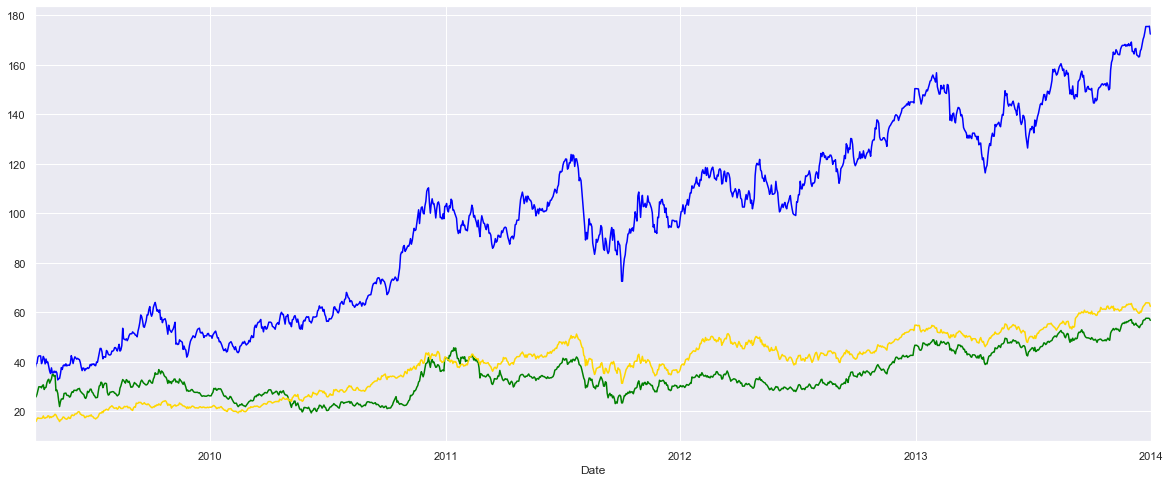

In [8]:
# Ploting to see how the 3 time series move over time 
# There is  similarities on how the series move which shows trends of the entire automobile industry market
# VW prices shift alot more in magnitude after the 3rd quater of 2009

df['vol'][start_date:end_date].plot(figsize= (20,8), color = "blue")
df['por'][start_date:end_date].plot(color = "green")
df['bmw'][start_date:end_date].plot(color = "gold")
plt.show()

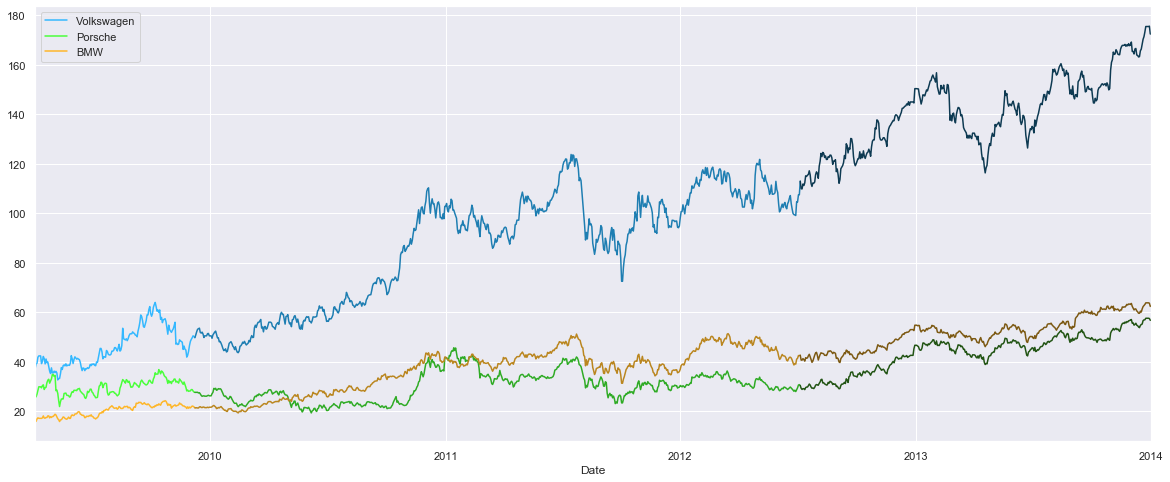

In [9]:
# For better visual using diffrent shades of colors
# The gap between VW and other 2 increases drastically over time
# BMW resemble Porsche much more

df['vol'][start_date:ann_1].plot(figsize= (20,8), color = "#33B8FF")
df['por'][start_date:ann_1].plot(color = "#49FF3A")
df['bmw'][start_date:ann_1].plot(color = "#FEB628")

df['vol'][ann_1:ann_2].plot(color = "#1E7EB2")
df['por'][ann_1:ann_2].plot(color = "#2FAB25")
df['bmw'][ann_1:ann_2].plot(color = "#BA861F")

df['vol'][ann_2:end_date].plot(color = "#0E3A52")
df['por'][ann_2:end_date].plot(color = "#225414")
df['bmw'][ann_2:end_date].plot(color = "#7C5913")

plt.legend(['Volkswagen','Porsche','BMW'])

plt.show()

## Correlation


In [10]:
# To see any similarities between the series
# Volkswagen and BMW correlation is the highest
# This shows VW moves in a similar way to the market benchmark, in higher values.

print('Correlation among manufacturers from ' + str(start_date) + ' to ' + str(end_date)+ '\n')
print('Volkswagen and Porsche correlation: \t'+ str(df['vol'][start_date:end_date].corr(df['por'][start_date:end_date])))
print('Volkswagen and BMW correlation: \t'+ str(df['vol'][start_date:end_date].corr(df['bmw'][start_date:end_date])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][start_date:end_date].corr(df['bmw'][start_date:end_date])))

Correlation among manufacturers from 2009-04-05 to 2014-01-01

Volkswagen and Porsche correlation: 	0.8359547164164512
Volkswagen and BMW correlation: 	0.9799378249373737
Porsche and BMW correlation: 		0.8052157916911932


In [11]:
# Correlation based on start date alone
# Porsche and BMW correlation is the lowest-this suggest the stock prices for the brands were not too similar before the start of the buyout


 
print('Correlation among manufacturers from ' + str(start_date) + ' to ' + str(ann_1)+ '\n')
print('Volkswagen and Porsche correlation: \t'+ str(df['vol'][start_date:ann_1].corr(df['por'][start_date:ann_1])))
print('Volkswagen and BMW correlation: \t'+ str(df['vol'][start_date:ann_1].corr(df['bmw'][start_date:ann_1])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][start_date:ann_1].corr(df['bmw'][start_date:ann_1])))

Correlation among manufacturers from 2009-04-05 to 2009-12-09

Volkswagen and Porsche correlation: 	0.6633584449543652
Volkswagen and BMW correlation: 	0.8427607817493326
Porsche and BMW correlation: 		0.6095038934500048


In [12]:
# changing the start and end data 
# Volkswagen and BMW correlation is the highest

print('Correlation among manufacturers from ' + str(ann_1) + ' to ' + str(ann_2)+ '\n')
print('Volkswagen and Porsche correlation: \t'+ str(df['vol'][ann_1:ann_2].corr(df['por'][ann_1:ann_2])))
print('Volkswagen and BMW correlation: \t'+ str(df['vol'][ann_1:ann_2].corr(df['bmw'][ann_1:ann_2])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][ann_1:ann_2].corr(df['bmw'][ann_1:ann_2])))

Correlation among manufacturers from 2009-12-09 to 2012-07-05

Volkswagen and Porsche correlation: 	0.7428267849870895
Volkswagen and BMW correlation: 	0.979594297759962
Porsche and BMW correlation: 		0.7042723078716628


In [13]:
# After buying Porsche
# the VW remains to be the market trend setter

print('Correlation among manufacturers from ' + str(ann_2) + ' to ' + str(end_date)+ '\n')
print('Volkswagen and Porsche correlation: \t'+ str(df['vol'][ann_2:end_date].corr(df['por'][ann_2:end_date])))
print('Volkswagen and BMW correlation: \t'+ str(df['vol'][ann_2:end_date].corr(df['bmw'][ann_2:end_date])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][ann_2:end_date].corr(df['bmw'][ann_2:end_date])))

Correlation among manufacturers from 2012-07-05 to 2014-01-01

Volkswagen and Porsche correlation: 	0.9405237174785851
Volkswagen and BMW correlation: 	0.9284447310955933
Porsche and BMW correlation: 		0.9494111736594026


In [14]:
# the correlation between VW and BMW decrease because of the Dieselgate Scandal
print('Correlation among manufacturers from ' + str(end_date) + ' to ' + str(df.index[-1])+ '\n')
print('Volkswagen and Porsche correlation: \t'+ str(df['vol'][end_date:].corr(df['por'][end_date:])))
print('Volkswagen and BMW correlation: \t'+ str(df['vol'][end_date:].corr(df['bmw'][end_date:])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][end_date:].corr(df['bmw'][end_date:])))

Correlation among manufacturers from 2014-01-01 to 2021-04-30 00:00:00

Volkswagen and Porsche correlation: 	0.9645773398506455
Volkswagen and BMW correlation: 	0.5867842623215198
Porsche and BMW correlation: 		0.5707941278918959


## Best Fitting Models

### For Volkswagen


In [15]:
mod_pr_pre_vol = auto_arima(df.vol[start_date:ann_1], exogenous = df[['por','bmw']][start_date:ann_1],
                            m = 5, max_p = 5, max_q = 5)
mod_pr_btn_vol = auto_arima(df.vol[ann_1:ann_2], exogenous = df[['por','bmw']][ann_1:ann_2],
                            m = 5, max_p = 5, max_q = 5)
mod_pr_post_vol = auto_arima(df.vol[ann_2:end_date], exogenous = df[['por','bmw']][ann_2:end_date],
                            m = 5, max_p = 5, max_q = 5)


In [16]:
# For period prior to First Official Announcement we see AR(1) model with 2 exog variables are best fit
# All P-values are significant so it is a best fit model

mod_pr_pre_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -327.180
Date:                Fri, 30 Apr 2021   AIC                            664.360
Time:                        05:47:47   BIC                            680.269
Sample:                    04-06-2009   HQIC                           670.811
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7404      0.458      1.618      0.106      -0.157       1.637
por            0.3997      0.096      4.169      0.000       0.212       0.588
bmw            0.6763      0.321      2.107      0.035       0.047       1.305
ar.L1          0.9633      0.020     48.670      0.000       0.925       1.002
sigma2         2.2785      0.155     14.718      0.000       1.975       2.582
===================================================================================
Ljung-Box (L1) (Q):                   0.77   Jarque-Bera (JB):               166.03
Prob(Q):                              0.38   Prob(JB):                         0.00
Heteroskedasticity (H):               1.61   Skew:                            -0.52
Prob(H) (two-sided):                  0.07   Kurtosis:                         7.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
# For period after the  First Official Announcement we see ARIMAX(0,1,0) model is the best fit
# The optimal model is an integrated one
# SInce auto Arima forces stationary so the data is non-stationary
# The model finds past residuals to have significant explanatory power 
    # "this indicate that the real life announcement actually changes the trend for VW prices"

mod_pr_btn_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  672
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1095.854
Date:                Fri, 30 Apr 2021   AIC                           2197.708
Time:                        05:47:47   BIC                           2211.234
Sample:                    12-09-2009   HQIC                          2202.947
                         - 07-05-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
por            0.7903      0.062     12.842      0.000       0.670       0.911
bmw            1.5139      0.071     21.269      0.000       1.374       1.653
sigma2         1.5349      0.063     24.532      0.000       1.412       1.658
===================================================================================
Ljung-Box (L1) (Q):                   2.07   Jarque-Bera (JB):               112.42
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               1.65   Skew:                             0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
mod_pr_post_vol.summary()

# The optimal model is ARIMAX(0,1,0)
#  The coefficient change in Porche Prices  occurs bcoz the 2 automobile manufactures are now a single entity
# This shows the price of Porche today will be more accurate estimator than the price of VW yesterday

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  390
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -616.936
Date:                Fri, 30 Apr 2021   AIC                           1239.872
Time:                        05:50:34   BIC                           1251.762
Sample:                    07-05-2012   HQIC                          1244.586
                         - 01-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
por            1.7180      0.057     30.369      0.000       1.607       1.829
bmw            0.8382      0.089      9.381      0.000       0.663       1.013
sigma2         1.3966      0.068     20.461      0.000       1.263       1.530
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):               103.79
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                            -0.39
Prob(H) (two-sided):                  0.15   Kurtosis:                         5.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Inference: New information seems to have a higher impact on trends compared to past patterns

### For Porsche

In [36]:

mod_pr_pre_por = auto_arima(df.por[start_date:ann_1], exogenous = df[['vol','bmw']][start_date:ann_1],
                            m = 5, max_p = 5, max_q = 5)
mod_pr_btn_por = auto_arima(df.por[ann_1:ann_2], exogenous = df[['vol','bmw']][ann_1:ann_2],
                            m = 5, max_p = 5, max_q = 5)
mod_pr_post_por = auto_arima(df.por[ann_2:end_date], exogenous = df[['vol','bmw']][ann_2:end_date],
                             m = 5, max_p = 5, max_q = 5)

In [38]:
# For period prior to First Official Announcement we see AR(2) model with 2 exog variables are best fit


mod_pr_pre_por.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -230.105
Date:                Fri, 30 Apr 2021   AIC                            472.209
Time:                        06:02:15   BIC                            491.300
Sample:                    04-06-2009   HQIC                           479.951
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5897      0.385      1.533      0.125      -0.164       1.344
vol            0.1151      0.053      2.157      0.031       0.011       0.220
bmw            0.8626      0.155      5.557      0.000       0.558       1.167
ar.L1          1.0747      0.059     18.194      0.000       0.959       1.191
ar.L2         -0.1589      0.059     -2.716      0.007      -0.274      -0.044
sigma2         0.7682      0.054     14.098      0.000       0.661       0.875
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               559.36
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.21   Skew:                            -0.96
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [41]:
# For period after the  First Official Announcement we see ARIMA(1,1,1) model is the best fit
# The optimal model is an integrated one
# the coefficent of VW has icrease 

mod_pr_btn_por.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  672
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -597.160
Date:                Fri, 30 Apr 2021   AIC                           1204.319
Time:                        06:07:07   BIC                           1226.863
Sample:                    12-09-2009   HQIC                          1213.051
                         - 07-05-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
vol            0.1786      0.016     11.134      0.000       0.147       0.210
bmw            0.3244      0.045      7.200      0.000       0.236       0.413
ar.L1          0.6585      0.230      2.860      0.004       0.207       1.110
ma.L1         -0.5898      0.246     -2.394      0.017      -1.073      -0.107
sigma2         0.3471      0.011     32.416      0.000       0.326       0.368
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1076.50
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.39   Skew:                             0.05
Prob(H) (two-sided):                  0.01   Kurtosis:                         9.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [42]:
mod_pr_post_por.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  390
Model:             SARIMAX(0, 1, 0)x(0, 0, [1], 5)   Log Likelihood                -219.646
Date:                             Fri, 30 Apr 2021   AIC                            447.292
Time:                                     06:07:09   BIC                            463.146
Sample:                                 07-05-2012   HQIC                           453.577
                                      - 01-01-2014                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
vol            0.2220      0.013     16.876      0.000       0.196       0.248
bmw            0.2450      0.041      6.036      0.000       0.165       0.325
ma.S.L5       -0.1249      0.057     -2.210      0.027      -0.236      -0.014
sigma2         0.1811      0.007     27.851      0.000       0.168       0.194
===================================================================================
Ljung-Box (L1) (Q):                   2.09   Jarque-Bera (JB):               613.59
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                             0.88
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Predictions for the Future

1. Taking the best fitting models and forcast them into the future
2. Comparing the predicition(based on data before the announcement) to the actual values following it
   means prediction for Volkswagen, time period  between the first and second  announcement based on    the trend prior to the first announcement


### For Volkswagen

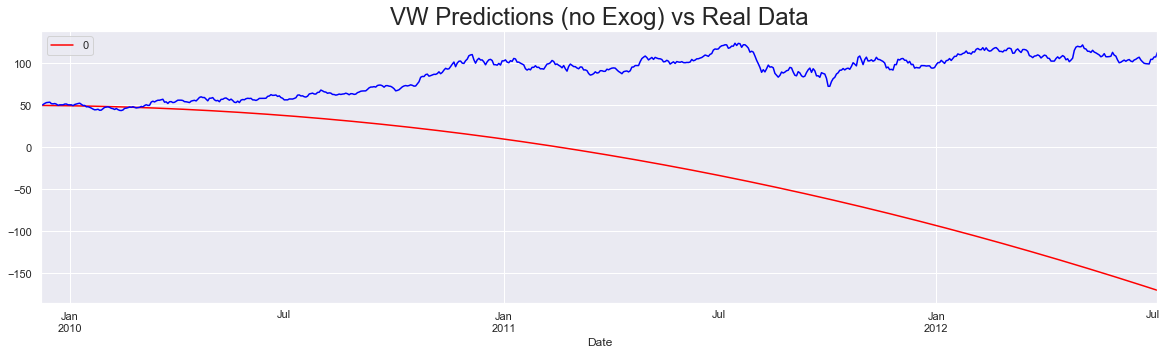

In [44]:
# Exogenous variable not inculded

model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1], m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5, trend = "ct")

df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods = len(df[ann_1:ann_2])), index = df[ann_1:ann_2].index)
df_auto_pred_pr[ann_1:ann_2].plot(figsize = (20,5), color = "red")

df.vol[ann_1:ann_2].plot(color = "blue")
plt.title("VW Predictions (no Exog) vs Real Data", size = 24)
plt.show()

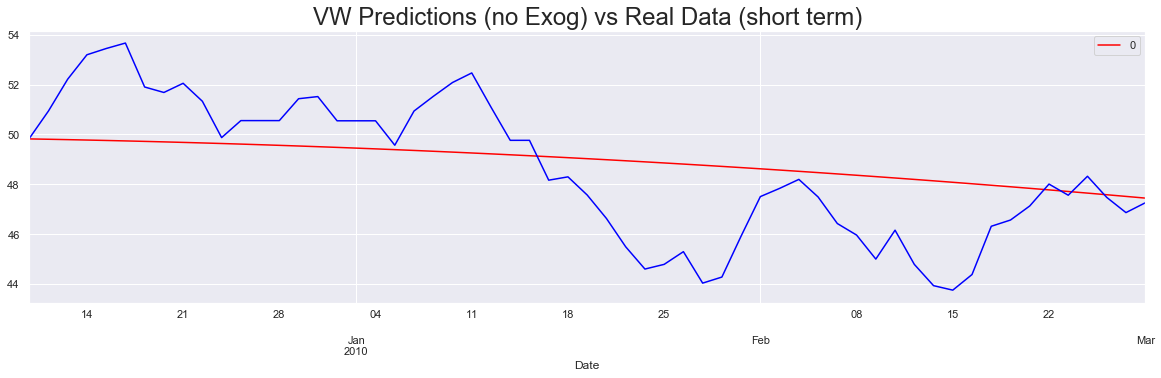

In [46]:
# showing only first quater of 2010
#  The prediciton not really close day-by-day but capture the general trend over the entire period
# So the prediciton would only be useful if we are trying to "ballpark"(or rough estimate) the quaterly performance

df_auto_pred_pr[ann_1:'2010-03-01'].plot(figsize = (20,5), color = "red")
df.vol[ann_1:'2010-03-01'].plot(color = "blue")
plt.title("VW Predictions (no Exog) vs Real Data (short term)", size = 24)
plt.show()

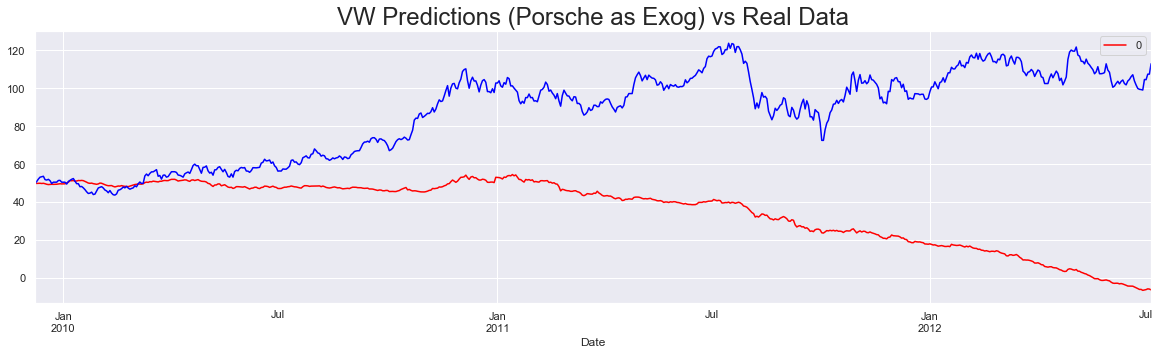

In [48]:
# Exog varaibles (Porsche prices) are included 
# We see a trend that doesnt simply die off exponentially
# Therefore adding Porsche prices improve predictions but not substantially 
#    (Since some portion og Porsche was owned by VW by 2010)
 
model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1], exogenous = df[['por']][start_date:ann_1],
                          m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5, trend = "ct")

df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods = len(df[ann_1:ann_2]),exogenous = df[['por']][ann_1:ann_2]),
                               index = df[ann_1:ann_2].index)
df_auto_pred_pr[ann_1:ann_2].plot(figsize = (20,5), color = "red")

df.vol[ann_1:ann_2].plot(color = "blue")
plt.title("VW Predictions (Porsche as Exog) vs Real Data", size = 24)

plt.show()

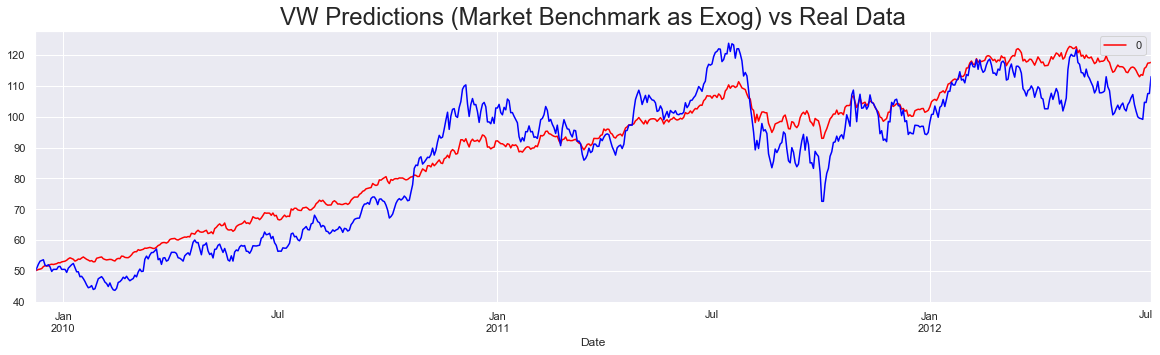

In [28]:
# Exog varaibles (BMW  prices) are included -using the market benchmark BMW
# The forecasts line up with general trend over the entire period
# But it doesnt justify the rise and fall periods 

model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1], exogenous = df[['bmw']][start_date:ann_1],
                          m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5, trend = "ct")

df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods = len(df[ann_1:ann_2]), exogenous = df[['bmw']][ann_1:ann_2]),
                               index = df[ann_1:ann_2].index)
df_auto_pred_pr[ann_1:ann_2].plot(figsize = (20,5), color = "red")

df.vol[ann_1:ann_2].plot(color = "blue")
plt.title("VW Predictions (Market Benchmark as Exog) vs Real Data", size = 24)
plt.show()

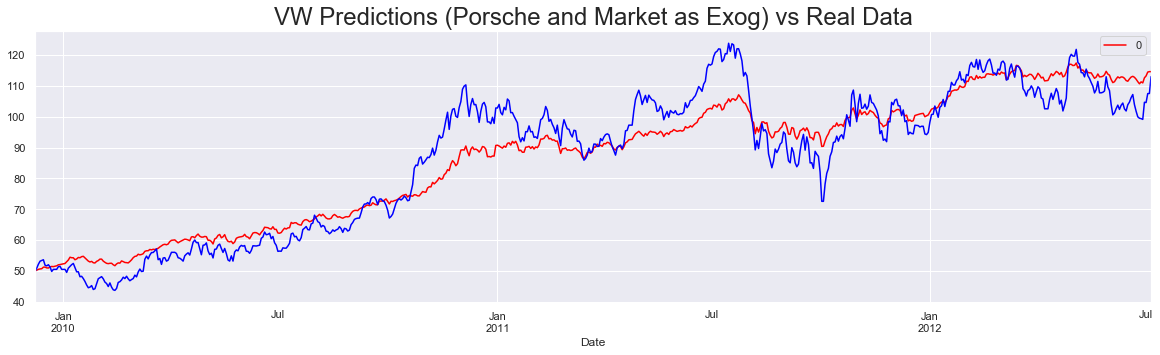

In [49]:
# Exog varaibles (BMW & Porsche prices) are included 
# Forecast look similar to when only including BMW prices
# This one matches the smaller shifts better 

model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1], exogenous = df[['por', 'bmw']][start_date:ann_1],
                          m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5, trend = "ct")

df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods = len(df[ann_1:ann_2]), exogenous = df[['por','bmw']][ann_1:ann_2]),
                               index = df[ann_1:ann_2].index)
df_auto_pred_pr[ann_1:ann_2].plot(figsize = (20,5), color = "red")

df.vol[ann_1:ann_2].plot(color = "blue")
plt.title("VW Predictions (Porsche and Market as Exog) vs Real Data", size = 24)
plt.show()

#### Inference : Introduction to new variables can alter our predictions drastically

## Volatility

### Volatility of VW for Each Period

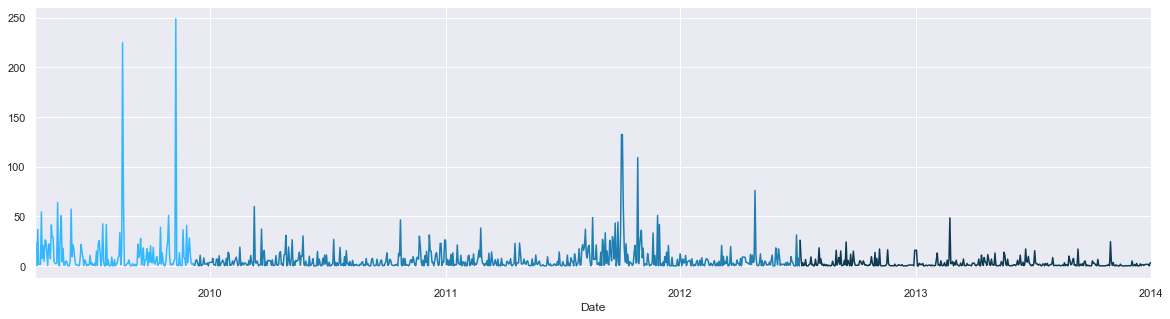

In [30]:
# Squared return represents the volatility of the stock
# VW has the highest volatility before any of the announcements
# Stock becomes extremely stable following each of the 2 announcements
# It shows instability to the time leading upto each purchase (may be bcoz of the rumors spreading accorss the market about a deal in the horizon)

df['sq_vol'][start_date:ann_1].plot(figsize = (20,5), color = "#33B8FF")
df['sq_vol'][ann_1:ann_2].plot(color = "#1E7EB2")
df['sq_vol'][ann_2:end_date].plot(color = "#0E3A52")
plt.show()

### Volatility Trends for Each Period

In [31]:
# applying GARCH(1,1) models for returns for 3 different periods


model_garch_pre = arch_model(df.ret_vol[start_date:ann_1], mean = "Constant",  vol = "GARCH", p = 1, q = 1)
results_garch_pre = model_garch_pre.fit(update_freq = 5)

model_garch_btn = arch_model(df.ret_vol[ann_1:ann_2], mean = "Constant",  vol = "GARCH", p = 1, q = 1)
results_garch_btn = model_garch_btn.fit(update_freq = 5)

model_garch_post = arch_model(df.ret_vol[ann_2:end_date], mean = "Constant",  vol = "GARCH", p = 1, q = 1)
results_garch_post = model_garch_post.fit(update_freq = 5)

Iteration:      5,   Func. Count:     31,   Neg. LLF: 475.7775372006258
Iteration:     10,   Func. Count:     56,   Neg. LLF: 475.00317765057133
Iteration:     15,   Func. Count:     80,   Neg. LLF: 474.9905156457213
Optimization terminated successfully    (Exit mode 0)
            Current function value: 474.9905155934316
            Iterations: 15
            Function evaluations: 80
            Gradient evaluations: 15
Iteration:      5,   Func. Count:     38,   Neg. LLF: 1526.7536027362708
Iteration:     10,   Func. Count:     62,   Neg. LLF: 1526.731671462164
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1526.7316714609192
            Iterations: 10
            Function evaluations: 62
            Gradient evaluations: 10
Iteration:      5,   Func. Count:     34,   Neg. LLF: 724.5624799318961
Optimization terminated successfully    (Exit mode 0)
            Current function value: 724.5581359827627
            Iterations: 7
            F

In [33]:
# Shows a P-value of 1 tells trends and variance are not persistent

results_garch_pre.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -474.991
Distribution:                  Normal   AIC:                           957.981
Method:            Maximum Likelihood   BIC:                           970.708
                                        No. Observations:                  178
Date:                Fri, Apr 30 2021   Df Residuals:                      177
Time:                        05:58:27   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1570      0.266      0.589      0.556 [ -0.365,  0.679]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega         10.6196      4.227      2.512  1.200e-02    [  2.334, 18.905]
alpha[1]       0.1540  9.194e-02      1.675  9.399e-02 [-2.623e-02,  0.334]
beta[1]    6.7760e-14      0.349  1.940e-13      1.000    [ -0.684,  0.684]
===========================================================================

Covariance estimator: robust
"""

In [34]:
# p-value  is zero means autocorrelation in the conditiona varaince is significant
# mu shows some constant trends in the returns value


results_garch_btn.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1526.73
Distribution:                  Normal   AIC:                           3061.46
Method:            Maximum Likelihood   BIC:                           3079.50
                                        No. Observations:                  672
Date:                Fri, Apr 30 2021   Df Residuals:                      671
Time:                        05:58:27   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1892  8.634e-02      2.191  2.843e-02 [1.998e-02,  0.358]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1679  7.914e-02      2.122  3.388e-02 [1.279e-02,  0.323]
alpha[1]       0.0688  1.682e-02      4.091  4.301e-05 [3.585e-02,  0.102]
beta[1]        0.9040  2.108e-02     42.884      0.000   [  0.863,  0.945]
==========================================================================

Covariance estimator: robust
"""

In [35]:
# shows change in volatility from previous time periods
# We never expect returns or their volatility to ever be perfectly stable which normal for a market lacking efficiency
results_garch_post.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -724.558
Distribution:                  Normal   AIC:                           1457.12
Method:            Maximum Likelihood   BIC:                           1472.98
                                        No. Observations:                  390
Date:                Fri, Apr 30 2021   Df Residuals:                      389
Time:                        05:58:27   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.2298  9.845e-02      2.334  1.958e-02 [3.685e-02,  0.423]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.7719      0.677      1.141      0.254    [ -0.554,  2.098]
alpha[1]       0.1853      0.145      1.273      0.203 [-9.991e-02,  0.470]
beta[1]        0.5136      0.331      1.550      0.121    [ -0.136,  1.163]
===========================================================================

Covariance estimator: robust
"""

### Conlusion 

Overall we see different volatility trends in all three periods.The purchase of Porsche led to the death of many rumors and provided Volkswagen with the larger share in the market which in turns results in lower volatility after each announcement, making VW stock a more appealing prospect